In [31]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import glob
import torchgeometry as tgm
from sympy import Derivative, symbols
import pandas as pd

# 필요한 모듈 가져오기
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline

# 데이터 불러오기

In [217]:
broken = Image.open('../data/broken_data/broken_sec_processed_data/20200519_44_broken_take0_final.jpg')
normal = Image.open('../data/normal_data/normal_sec_processed_data/20200518_44_normal_take0_final.jpg')
broken = np.array(broken)
normal = np.array(normal)

In [218]:
def calculateVectors(src, thres = 40):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)

    # 바이너리로 변환
    ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    height = src.shape[0]
    width = src.shape[1]

    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x] !=255 :            
                R.append([y, x])

    # 질량의 합
    M = len(R)

    # 질량중심 벡터는 이미지를 기준으로 (x,y)
    R = np.array(R)
    R_x = R[:,1]
    R_y = R[:,0]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_y_sum/M) , (np.round(R_x_sum/M))

    height_center = center[0]
    width_center = center[1]

    print('center:', height_center, width_center)


    ############################################################################
    # <객체 외부의 노이즈 데이터 처리하기>

    # 바이너리의 윤곽선 추출
    _, contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)    

    # 생두 객체 윤곽과 윤곽벡터 구하기
    contours_leng = [len(i) for i in contours if len(i) != 252]
    # print('contours_leng: ', contours_leng)
    max = np.array(contours_leng).max()
    # print('max: ', max)
    contour_vector_from_center = list()
    contour_vector = list()
    for i in contours:
        if len(i) == max:
            # print(i)
            for point in i:
                contour_vector.append((point[0][1], point[0][0]))
                contour_vector_from_center.append((point[0][1]-height_center, point[0][0]-width_center))
    # print('counts of contour vector: ', len(contour_vector))
    # print(contour_vector)
    # print(contour_vector_from_center)
    return contour_vector, contour_vector_from_center, src, binary, center, R

In [219]:
contour_vector1, contour_vector_from_center1, normal, binary1, center1, R1 = calculateVectors(normal)
vectors1 = np.concatenate([np.array(contour_vector1),np.array(contour_vector_from_center1)], axis = 1)
vectors_size1 = np.sqrt(vectors1[:,2]**2 + vectors1[:,3]**2).reshape(vectors1.shape[0],1)
final_array1 = np.concatenate([vectors1, vectors_size1], axis = 1)

center: 32.0 32.0


In [220]:
contour_vector2, contour_vector_from_center2, broken, binary2, center2, R2 = calculateVectors(broken)
vectors2 = np.concatenate([np.array(contour_vector2),np.array(contour_vector_from_center2)], axis = 1)
vectors_size2 = np.sqrt(vectors2[:,2]**2 + vectors2[:,3]**2).reshape(vectors2.shape[0],1)
final_array2 = np.concatenate([vectors2, vectors_size2], axis = 1)

center: 32.0 33.0


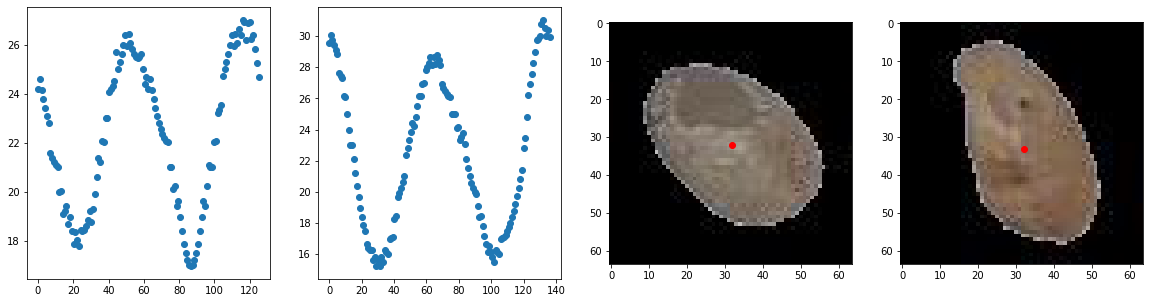

In [221]:
x_normal = np.linspace(0, final_array1.shape[0], final_array1.shape[0])
x_broken = np.linspace(0, final_array2.shape[0], final_array2.shape[0])
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,4,1)
ax1.scatter(x_normal, final_array1[:,4])
ax2 = fig.add_subplot(1,4,2)
ax2.scatter(x_broken, final_array2[:,4])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(normal)
ax3.scatter(center1[0], center1[1], c = 'red')
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(broken)
ax4.scatter(center2[0], center2[1], c = 'red')

# 변화율 계산하기
- delta y / delta x
- delta x = 1pixel

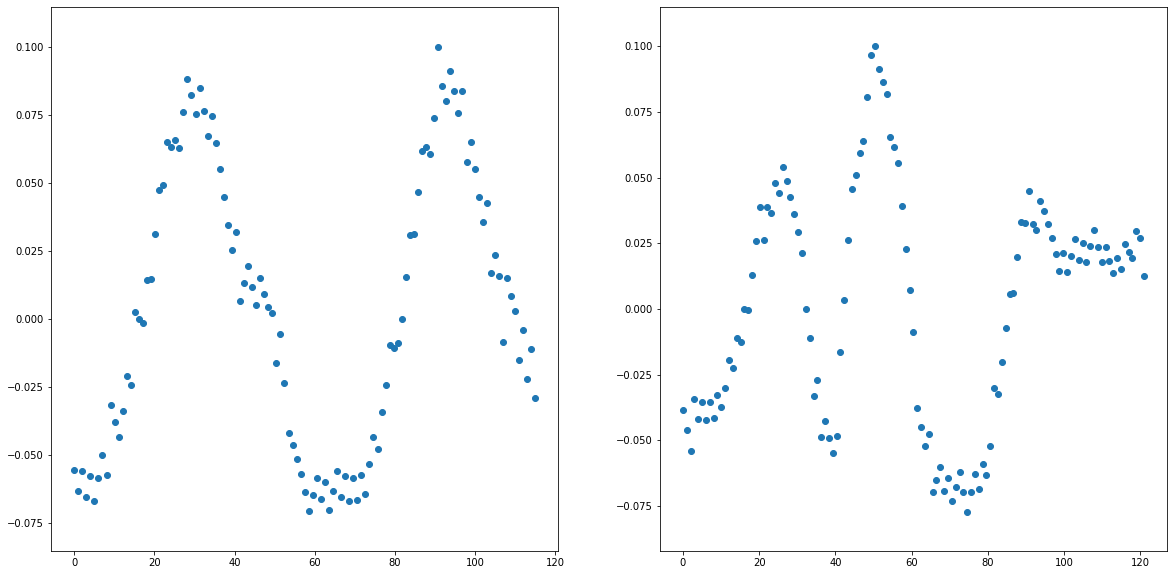

In [191]:
delta_x = 10
x_d_1 = np.linspace(0, final_array1.shape[0]-delta_x, final_array1.shape[0]-delta_x)
x_d_2 = np.linspace(0, final_array2.shape[0]-delta_x, final_array2.shape[0]-delta_x)
delta_y_1 = (final_array1[:, 4][delta_x:] - final_array1[:, 4][:-delta_x]) / (final_array1[:, 4][delta_x:] - final_array1[:, 4][:-delta_x]).max()
delta_y_2 = (final_array2[:, 4][delta_x:] - final_array2[:, 4][:-delta_x]) / (final_array2[:, 4][delta_x:] - final_array2[:, 4][:-delta_x]).max()
derivative1 = delta_y_1 / delta_x
derivative2 = delta_y_2 / delta_x
# delta_y
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(x_d_1, derivative1)
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(x_d_2, derivative2)


In [214]:
R1[:,0].sum()/len(R1)

32.09634317862166

In [215]:
R2[:,1].sum()/len(R2)

32.358404185742316

3